In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

server = "localhost,5432"
db_name = "ModMon"
driver = "/usr/local/lib/psqlodbcw.so"

cnxn = pyodbc.connect("DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + db_name + ";Trusted_Connection=yes;")
cursor = cnxn.cursor()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
models = pd.read_sql('SELECT models.modelID, models.name, models.teamName, models.description, researchQuestions.description AS question FROM models, researchQuestions WHERE models.questionID=researchQuestions.questionID;', cnxn)
models

,modelid,name,teamname,description,question
0,1,synpuf_stats,REG,"Not really a model, descriptive stats",Descriptive stats for Synpuf database
1,2,synpuf-R,Another Team,Bag of words model,synpuf


Visualisation ideas
==

In [3]:
results = pd.read_sql('SELECT * FROM results;', cnxn)
results.head()

,modelid,modelversion,testdatasetid,isreferenceresult,runtime,runid,metric,value,valueerror,resultmessage
0,1,0.0.1,2,1,2020-01-01,1,jan_births,23.0,None,None
1,1,0.0.1,2,1,2020-01-01,1,aug_births,13.0,None,None
2,1,0.0.1,2,1,2020-01-01,1,born_60,1.0,None,None
3,1,0.0.1,2,1,2020-01-01,1,population_size,200.0,None,None
4,1,0.0.1,2,1,2020-01-01,1,mortality,5.0,None,None


[Text(0, 0.5, 'Runs in ModMon DB'), Text(0.5, 0, 'Model')]

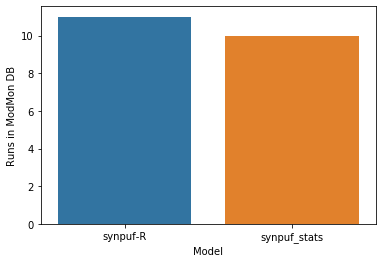

In [4]:
# Number of times each model has been run
query = """
SELECT m.name, COUNT( DISTINCT r.runid )
FROM results AS r, models AS m
WHERE r.modelid = m.modelid
GROUP BY m.name;
"""
data = pd.read_sql(query, cnxn)
bar = sns.barplot(x='name', y='count', data=data)
bar.set(xlabel='Model', ylabel="Runs in ModMon DB")

## View a particular metric for a model across time and for different versions

In [5]:
metric = 'mortality'
model = 1
query = """
SELECT r.metric, r.value, r.modelversion, d.databasename
FROM results AS r, datasets AS d
WHERE modelID={}
AND r.testdatasetid = d.datasetid
AND metric='{}';
""".format(model, metric)
plot3_results = pd.read_sql(query, cnxn)
plot3_results

,metric,value,modelversion,databasename
0,mortality,5.00,0.0.1,WEEK_01
1,mortality,5.00,0.0.1,WEEK_01
2,mortality,4.75,0.0.1,WEEK_03
3,mortality,4.80,0.0.1,WEEK_04
4,mortality,5.00,0.0.1,WEEK_05
5,mortality,5.00,0.0.1,WEEK_06
6,mortality,5.00,0.0.1,WEEK_07
7,mortality,5.00,0.0.1,WEEK_08
8,mortality,5.00,0.0.1,WEEK_09
9,mortality,5.20,0.0.1,WEEK_10


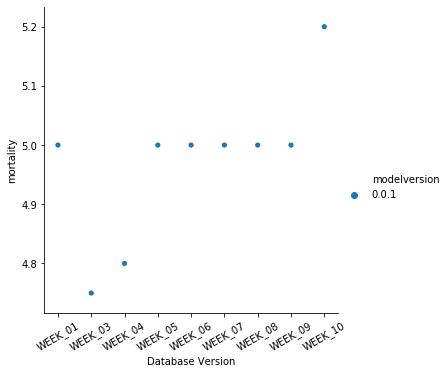

In [6]:
chart = sns.relplot(x='databasename', y='value', hue='modelversion', data=plot3_results)
chart.set_xticklabels(rotation=30)
chart.set(xlabel='Database Version', ylabel=metric)
chart

In [58]:
query = """
SELECT m.name, r.metric, r.value, d.databasename
FROM results AS r, datasets AS d, models AS m, modelVersions AS mv
WHERE r.testdatasetid = d.datasetid
AND r.modelid = m.modelid
AND mv.active;
"""
results = pd.read_sql(query, cnxn)
results

,name,metric,value,databasename
0,synpuf_stats,jan_births,23.0000,WEEK_01
1,synpuf_stats,jan_births,23.0000,WEEK_01
2,synpuf_stats,aug_births,13.0000,WEEK_01
3,synpuf_stats,aug_births,13.0000,WEEK_01
4,synpuf_stats,born_60,1.0000,WEEK_01
...,...,...,...,...
159,synpuf_stats,average_onset_duration,76.0000,WEEK_10
160,synpuf-R,AUC,0.5078,WEEK_10
161,synpuf-R,AUC,0.5078,WEEK_10
162,synpuf-R,LogLoss,0.7080,WEEK_10


In [66]:
a = ['a'] * 8
a

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']

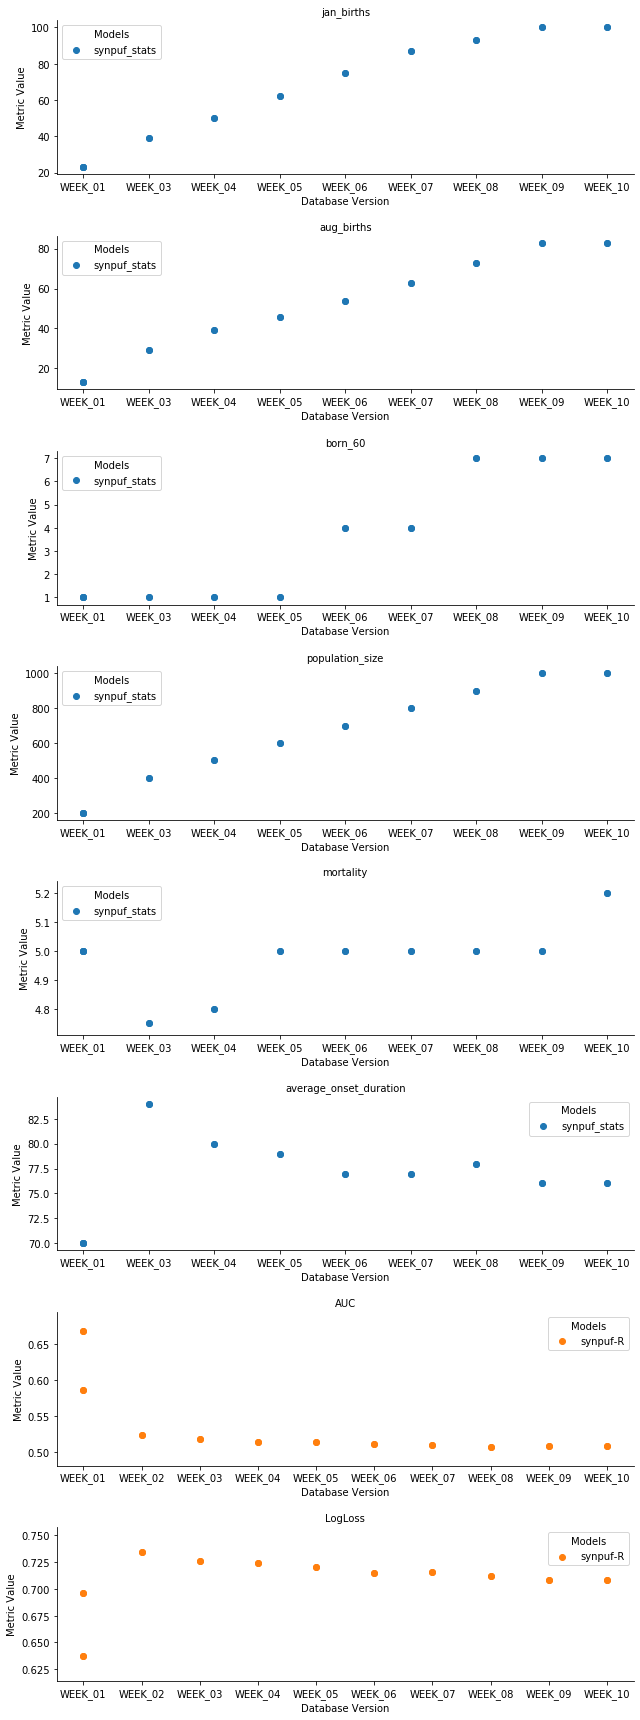

In [105]:
g = sns.FacetGrid(data=results, row='metric', sharey=False, sharex=False, aspect=3, hue='name')
g.map(plt.scatter, "databasename", "value").fig.subplots_adjust(hspace=.4)
# g.set_xticklabels(rotation=45)
g.set(xlabel='Database Version', ylabel='Metric Value')
g.set_titles(col_template = "{col_name}", row_template = '{row_name}')
for i, _ in enumerate(g.axes):
    g.axes[i][0].legend(title = "Models")

# plt.legend(loc='upper left')
# plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]